In [ ]:
%pip install datasets nltk
%pip install torchtext==0.12.0
%pip install -U portalocker>=2.0.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package punkt to /home/s12gb1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Data preparation

In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb")
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
    for data in data_iter:
        yield tokenizer(data["text"])

vocab = build_vocab_from_iterator(yield_tokens(train_data),
                                  min_freq = 3,
                                  max_tokens=vocab_size,
                                  specials=["<pad>", "<s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
seq_length = 200
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch, seq_length=seq_length):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample['label'])

        text_processed = text_pipeline(sample['text'])[:seq_length]
        if len(text_processed) < seq_length:
            pad_size = seq_length - len(text_processed) -1
            text_processed = [vocab["<pad>"]] * pad_size + [vocab["<s>"]] + text_processed
        text_list.append(text_processed)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return (input_ids, labels)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

# 2. Model

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.0, bias=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2


class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.pos_emb = nn.Embedding(num_embeddings=max_length, embedding_dim=embed_dim)

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output


class TransformerTextCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device):
        super().__init__()
        self.embd_layer = TokenAndPositionEmbedding(vocab_size, embed_dim, max_length, device)
        self.transformer_layer = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


In [ ]:
max_length = seq_length #200
embed_dim = 32
num_heads = 2
ff_dim = 32
dropout = 0.1
model = TransformerTextCls(vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device)

# 3. Evaluate

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

# 4. Train

In [ ]:
max_epoch = 20
LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 0.6222, Accuracy: 63.90%, Test Loss: 0.5838, Test Accuracy: 69.64%
Epoch [2/20], Loss: 0.4577, Accuracy: 78.89%, Test Loss: 0.5406, Test Accuracy: 73.96%
Epoch [3/20], Loss: 0.3752, Accuracy: 83.40%, Test Loss: 0.5606, Test Accuracy: 74.43%
Epoch [4/20], Loss: 0.3177, Accuracy: 86.52%, Test Loss: 0.5977, Test Accuracy: 74.21%
Epoch [5/20], Loss: 0.2831, Accuracy: 88.18%, Test Loss: 0.4702, Test Accuracy: 79.52%
Epoch [6/20], Loss: 0.2457, Accuracy: 90.10%, Test Loss: 0.4479, Test Accuracy: 81.43%
Epoch [7/20], Loss: 0.2144, Accuracy: 91.55%, Test Loss: 0.5282, Test Accuracy: 79.05%
Epoch [8/20], Loss: 0.1926, Accuracy: 92.32%, Test Loss: 0.5762, Test Accuracy: 78.51%
Epoch [9/20], Loss: 0.1719, Accuracy: 93.45%, Test Loss: 0.5141, Test Accuracy: 81.45%
Epoch [10/20], Loss: 0.1550, Accuracy: 94.02%, Test Loss: 0.6025, Test Accuracy: 78.81%
Epoch [11/20], Loss: 0.1343, Accuracy: 94.95%, Test Loss: 0.6016, Test Accuracy: 80.75%
Epoch [12/20], Loss: 0.1220, Accuracy: 95

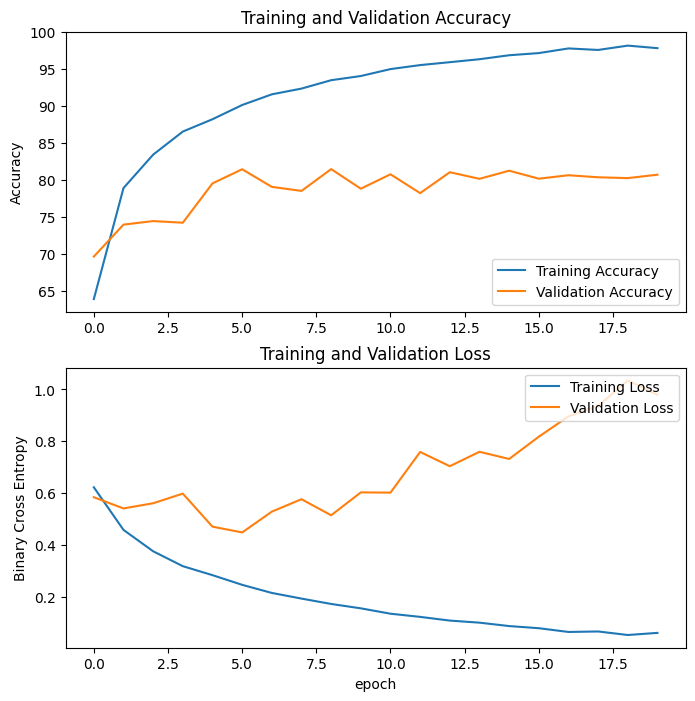

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()